# Compute embeddings and plot distances

This notebook computes embeddings using `sentence-transformers/all-MiniLM-L6-v2` for the **context** (precontext + sentence + ending), the **definition** (`judged_meaning`), the **example** (`example_sentence`) and the **word** (`homonym`).

It merges `train.json` and `dev.json`, then plots two 2D scatter plots:
- x axis: **average** score (1--5)
- y axis: **cosine distance** (context vs definition) (left)
- y axis: **Euclidean distance** (context vs definition) (right)

In [1]:
# Imports
import json
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

/home/niccolo/Torino/LLM-SamEval-T5/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and merge datasets
data_dir = Path("../data").resolve()
train_path = data_dir / "train.json"
dev_path = data_dir / "dev.json"

train = pd.read_json(train_path, orient="index")
dev = pd.read_json(dev_path, orient="index")

df = pd.concat([train, dev], ignore_index=True)
print(f"Loaded train: {train.shape}, dev: {dev.shape} -> merged: {df.shape}")
df.head()

Loaded train: (2280, 11), dev: (588, 11) -> merged: (2868, 11)


,homonym,judged_meaning,precontext,sentence,ending,choices,average,stdev,nonsensical,sample_id,example_sentence
0,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[4, 5, 2, 3, 1]",3.0,1.581139,"[False, False, False, False, False]",1843,The circuit has a high potential difference.
1,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[5, 3, 4, 4, 3]",3.8,0.836660,"[False, False, False, False, False]",1844,The project has great potential for success.
2,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[2, 1, 4, 3, 1]",2.2,1.303840,"[False, False, False, False, False]",1845,The circuit has a high potential difference.
3,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[4, 5, 5, 3, 5]",4.4,0.894427,"[False, False, False, False, False]",1846,The project has great potential for success.
4,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,,"[1, 1, 4, 4, 3]",2.6,1.516575,"[False, False, False, False, False]",1847,The circuit has a high potential difference.


In [3]:
# Prepare text fields
def make_context(row):
	parts = [str(row.get(c, "")) for c in ("precontext", "sentence", "ending")]
	text = " ".join([p.strip() for p in parts if p and p.strip()])
	return text

df["context"] = df.apply(make_context, axis=1)
df["definition"] = df["judged_meaning"].astype(str)
df["example"] = df.get("example_sentence", "").astype(str)
df["word"] = df["homonym"].astype(str)
df["average"] = df["average"].astype(float)

# Optionally reduce size for quick iteration
SAMPLE = None  # set to an int for a quick run, e.g. 5000
if SAMPLE:
	df = df.sample(SAMPLE, random_state=42).reset_index(drop=True)

print("Prepared text fields. Examples:")
df[["context", "definition", "example", "word", "average"]].head()

Prepared text fields. Examples:


,context,definition,example,word,average
0,The old machine hummed in the corner of the wo...,the difference in electrical charge between tw...,The circuit has a high potential difference.,potential,3.0
1,The old machine hummed in the corner of the wo...,the inherent capacity for coming into being,The project has great potential for success.,potential,3.8
2,The old machine hummed in the corner of the wo...,the difference in electrical charge between tw...,The circuit has a high potential difference.,potential,2.2
3,The old machine hummed in the corner of the wo...,the inherent capacity for coming into being,The project has great potential for success.,potential,4.4
4,The old machine hummed in the corner of the wo...,the difference in electrical charge between tw...,The circuit has a high potential difference.,potential,2.6


In [4]:
# Compute embeddings with all-MiniLM-L6-v2
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

BATCH_SIZE = 128

texts_context = df["context"].tolist()
texts_definition = df["definition"].tolist()
texts_example = df["example"].tolist()
texts_word = df["word"].tolist()

print("Encoding context...")
emb_context = model.encode(texts_context, batch_size=BATCH_SIZE, show_progress_bar=True, convert_to_numpy=True)
print("Encoding definition...")
emb_definition = model.encode(texts_definition, batch_size=BATCH_SIZE, show_progress_bar=True, convert_to_numpy=True)
print("Encoding example (may be unused)...")
emb_example = model.encode(texts_example, batch_size=BATCH_SIZE, show_progress_bar=True, convert_to_numpy=True)
print("Encoding word (homonym)...")
emb_word = model.encode(texts_word, batch_size=BATCH_SIZE, show_progress_bar=True, convert_to_numpy=True)

print("Embeddings shapes:", emb_context.shape, emb_definition.shape, emb_example.shape, emb_word.shape)

Encoding context...


Batches: 100%|██████████| 23/23 [00:01<00:00, 17.17it/s]



Encoding definition...


Batches: 100%|██████████| 23/23 [00:00<00:00, 68.76it/s]



Encoding example (may be unused)...


Batches: 100%|██████████| 23/23 [00:00<00:00, 88.99it/s]



Encoding word (homonym)...


Batches: 100%|██████████| 23/23 [00:00<00:00, 135.53it/s]

Embeddings shapes: (2868, 384) (2868, 384) (2868, 384) (2868, 384)


In [5]:

# Compute cosine distances using sklearn (elementwise: diagonal of pairwise matrix)
cos_dist = cosine_distances(emb_context, emb_definition).diagonal()
cos_sim = cosine_similarity(emb_context, emb_definition).diagonal()

# Euclidean distance (unchanged)
eucl_dist = np.linalg.norm(emb_context - emb_definition, axis=1)
eucl_dist_ex = np.linalg.norm(emb_context - emb_example, axis=1)

# Attach to DataFrame
df["cosine_distance_ctx_def"] = cos_dist
df["euclidean_distance_ctx_def"] = eucl_dist

df["euclidean_distance_ctx_ex"] = eucl_dist_ex

# Optionally compute context-example and context-word distances using sklearn
df["cosine_distance_ctx_ex"] = cosine_distances(emb_context, emb_example).diagonal()
df["cosine_distance_ctx_word"] = cosine_distances(emb_context, emb_word).diagonal()

print("Distances computed. Sample:")
df[["average", "cosine_distance_ctx_def", "euclidean_distance_ctx_def"]].head()

Distances computed. Sample:


,average,cosine_distance_ctx_def,euclidean_distance_ctx_def
0,3.0,0.952082,1.379915
1,3.8,0.956160,1.382866
2,2.2,1.044914,1.445623
3,4.4,0.958139,1.384297
4,2.6,1.003675,1.416810


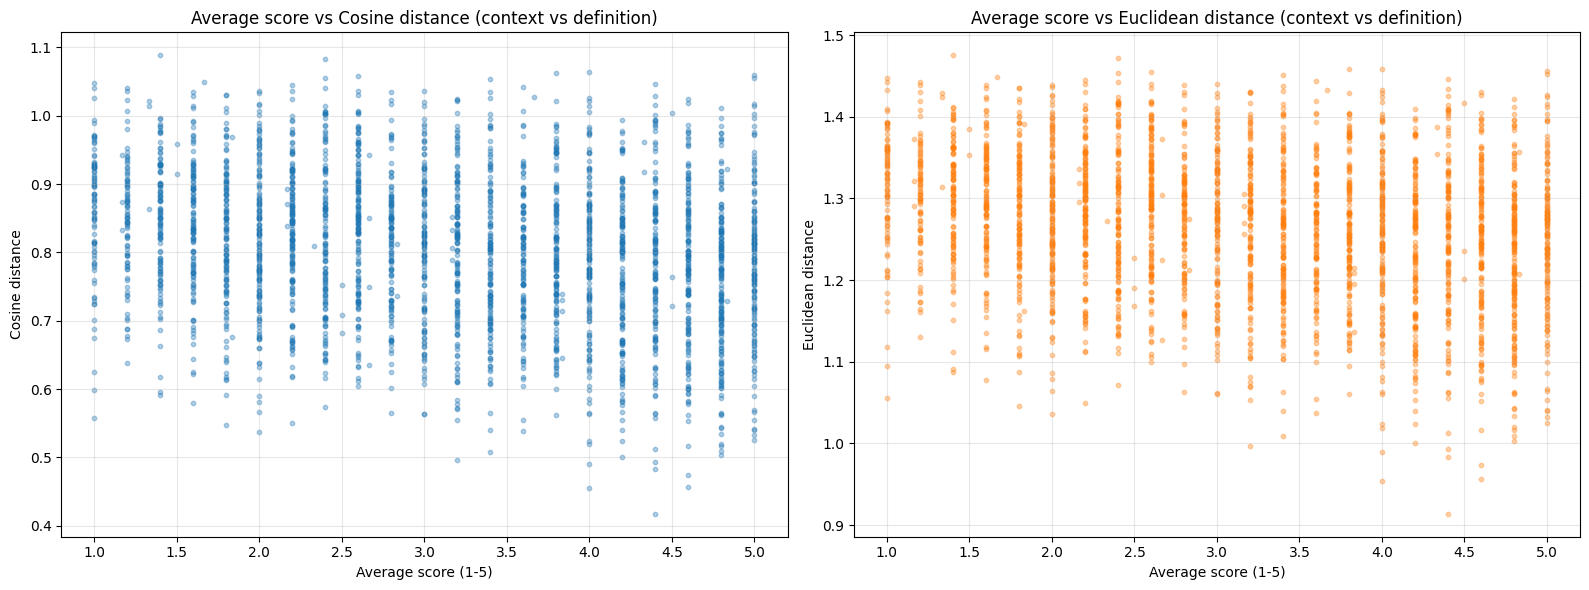

In [6]:
# Plotting: 2D scatter for cosine and Euclidean distances
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Cosine distance plot
ax = axes[0]
ax.scatter(df["average"], df["cosine_distance_ctx_def"], alpha=0.35, s=10)
ax.set_title("Average score vs Cosine distance (context vs definition)")
ax.set_xlabel("Average score (1-5)")
ax.set_ylabel("Cosine distance")
ax.grid(True, alpha=0.3)

# Euclidean distance plot
ax = axes[1]
ax.scatter(df["average"], df["euclidean_distance_ctx_def"], alpha=0.35, s=10, color="C1")
ax.set_title("Average score vs Euclidean distance (context vs definition)")
ax.set_xlabel("Average score (1-5)")
ax.set_ylabel("Euclidean distance")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

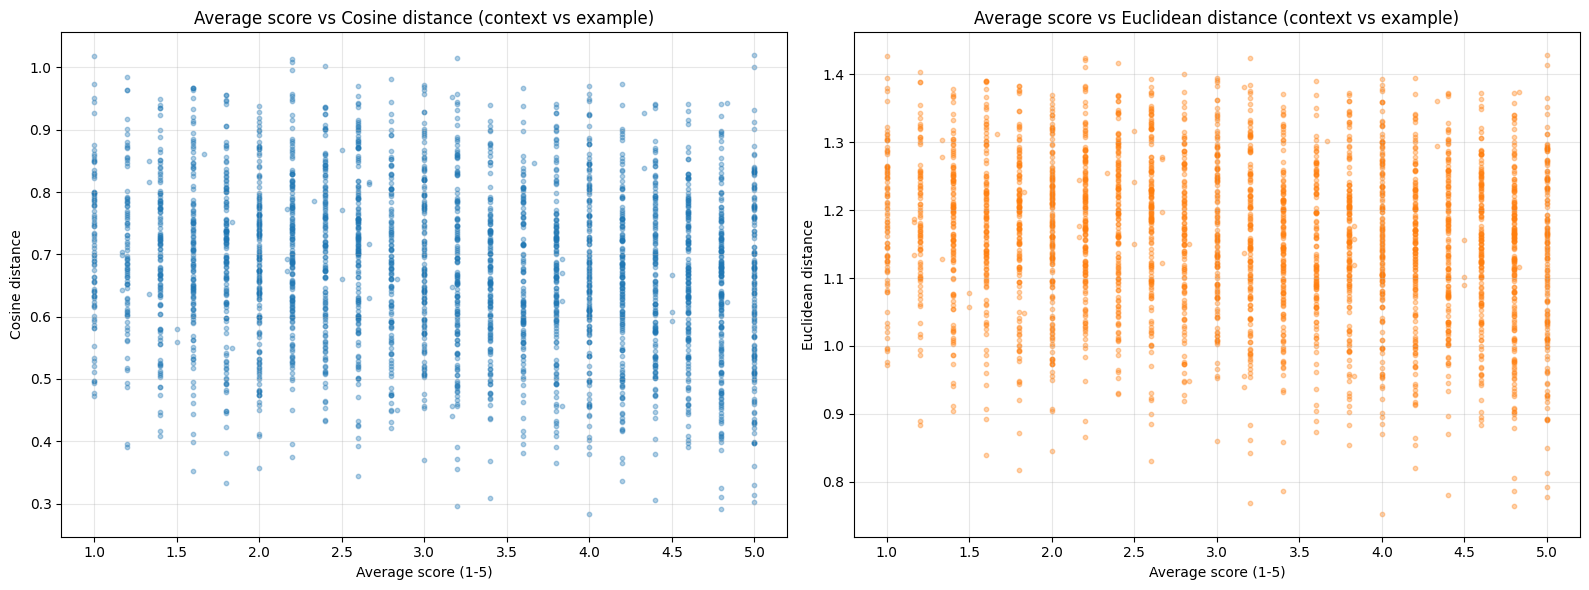

In [7]:
# Plotting: 2D scatter for cosine and Euclidean distances
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Cosine distance plot
ax = axes[0]
ax.scatter(df["average"], df["cosine_distance_ctx_ex"], alpha=0.35, s=10)
ax.set_title("Average score vs Cosine distance (context vs example)")
ax.set_xlabel("Average score (1-5)")
ax.set_ylabel("Cosine distance")
ax.grid(True, alpha=0.3)

# Euclidean distance plot
ax = axes[1]
ax.scatter(df["average"], df["euclidean_distance_ctx_ex"], alpha=0.35, s=10, color="C1")
ax.set_title("Average score vs Euclidean distance (context vs example)")
ax.set_xlabel("Average score (1-5)")
ax.set_ylabel("Euclidean distance")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Hypothesis-based embeddings (definition + example)

Create a hypothesis text following the DeBERTa finetune format and compute distances between the **context** and this **hypothesis** (definition + example combined). Then plot the same 2D scatter (average vs distance).

In [8]:
# Build hypothesis text using the same template as in the finetuning notebooks
def make_hypothesis(row):
	hom = row.get("homonym", "")
	meaning = row.get("judged_meaning", "")
	example = row.get("example_sentence", "")
	# Template used in DeBERTa finetuning notebooks
	return f'The definition of "{hom}" is: "{meaning}" as in the following sentence: "{example}"'

df["hypothesis"] = df.apply(make_hypothesis, axis=1)
df["hypothesis"].head()

0    The definition of "potential" is: "the differe...
1    The definition of "potential" is: "the inheren...
2    The definition of "potential" is: "the differe...
3    The definition of "potential" is: "the inheren...
4    The definition of "potential" is: "the differe...
Name: hypothesis, dtype: object

In [9]:
# Encode hypothesis and compute distances against context
texts_hypothesis = df["hypothesis"].tolist()
print("Encoding hypothesis texts...")
emb_hypothesis = model.encode(texts_hypothesis, batch_size=BATCH_SIZE, show_progress_bar=True, convert_to_numpy=True)

# Cosine distance
cos_sim_h = np.sum(emb_context * emb_hypothesis, axis=1) / (np.linalg.norm(emb_context, axis=1) * np.linalg.norm(emb_hypothesis, axis=1) + 1e-8)
df["cosine_distance_ctx_hyp"] = 1.0 - cos_sim_h

# Euclidean distance
df["euclidean_distance_ctx_hyp"] = np.linalg.norm(emb_context - emb_hypothesis, axis=1)

print("Hypothesis distances computed. Sample:")
df[["average", "cosine_distance_ctx_hyp", "euclidean_distance_ctx_hyp"]].head()

Encoding hypothesis texts...


Batches: 100%|██████████| 23/23 [00:00<00:00, 32.56it/s]

Hypothesis distances computed. Sample:


,average,cosine_distance_ctx_hyp,euclidean_distance_ctx_hyp
0,3.0,0.962650,1.387552
1,3.8,0.954986,1.382017
2,2.2,1.046558,1.446760
3,4.4,0.996572,1.411788
4,2.6,0.957557,1.383876


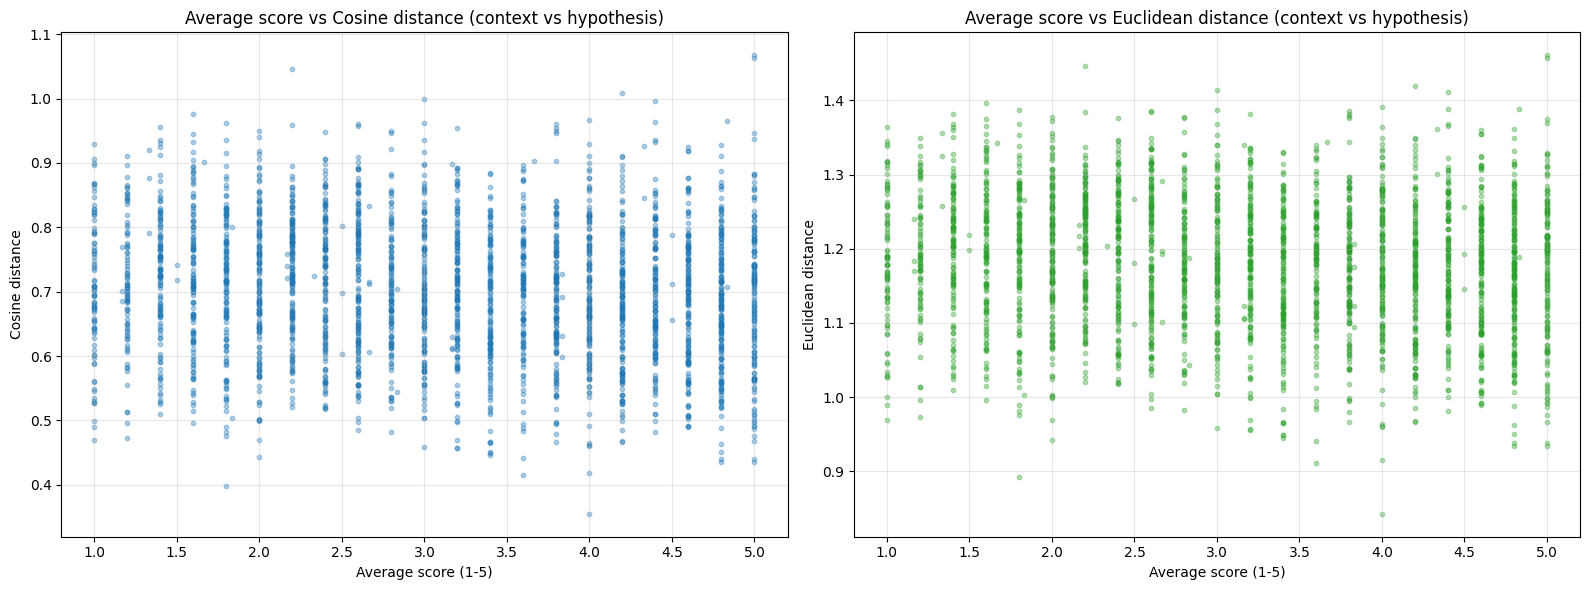

In [10]:
# Plotting: 2D scatter for hypothesis distances
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Cosine distance (context vs hypothesis)
ax = axes[0]
ax.scatter(df["average"], df["cosine_distance_ctx_hyp"], alpha=0.35, s=10)
ax.set_title("Average score vs Cosine distance (context vs hypothesis)")
ax.set_xlabel("Average score (1-5)")
ax.set_ylabel("Cosine distance")
ax.grid(True, alpha=0.3)

# Euclidean distance (context vs hypothesis)
ax = axes[1]
ax.scatter(df["average"], df["euclidean_distance_ctx_hyp"], alpha=0.35, s=10, color="C2")
ax.set_title("Average score vs Euclidean distance (context vs hypothesis)")
ax.set_xlabel("Average score (1-5)")
ax.set_ylabel("Euclidean distance")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Per-dimension correlation between context and hypothesis embeddings

Compute Pearson correlation for each embedding dimension between context and hypothesis embeddings, grouped by rounded **average** score (1..5). Plot:
- Line plot: per-dimension correlation (x = embedding dim, y = Pearson r) for each average bin
- Boxplot: distribution of per-dimension correlations per average bin

This helps check whether low-average items show negative correlations and high-average ones positive correlations across dimensions.

Average bins found: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Bin 1: count=290, mean corr=0.2801, median corr=0.2790
Bin 2: count=699, mean corr=0.2769, median corr=0.2805
Bin 3: count=686, mean corr=0.2966, median corr=0.2993
Bin 4: count=706, mean corr=0.3046, median corr=0.3071
Bin 5: count=487, mean corr=0.3129, median corr=0.3201


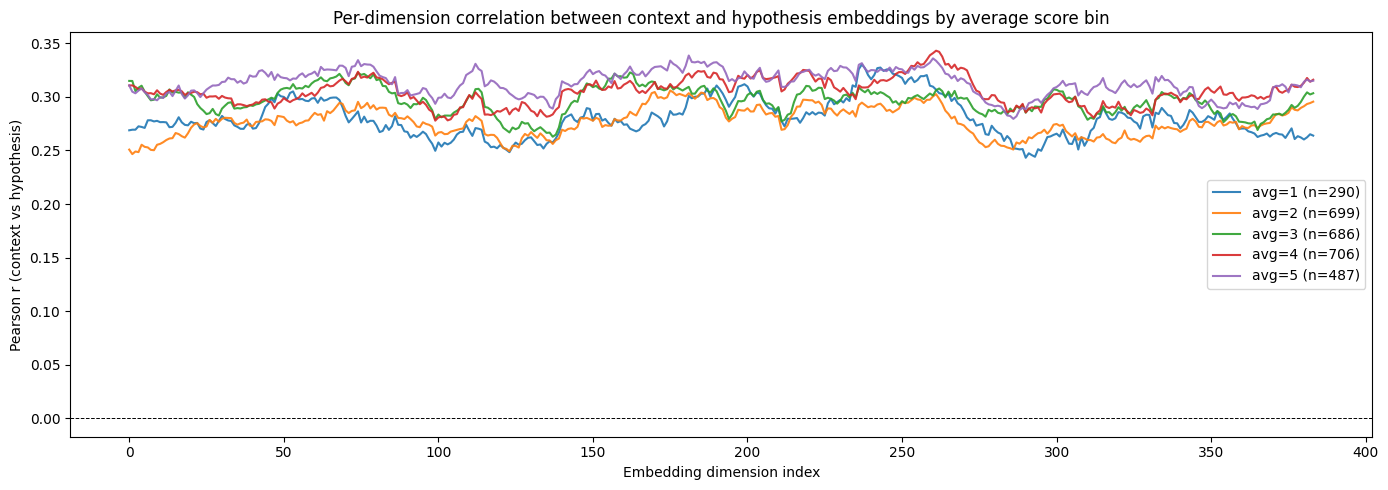

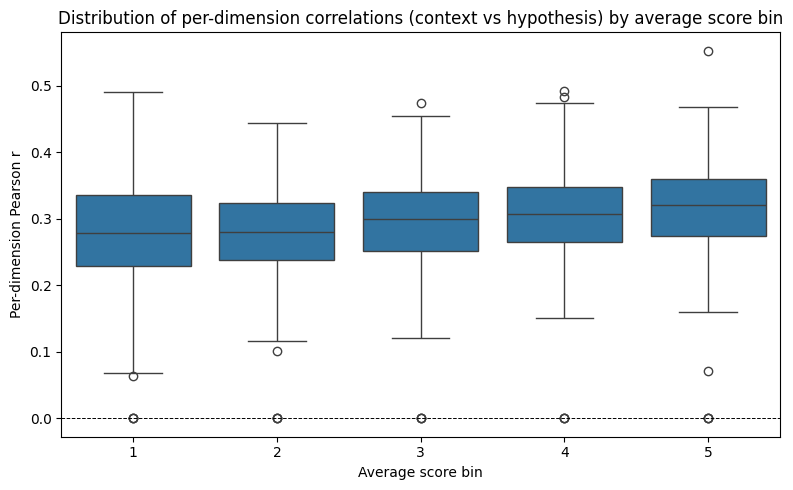

In [11]:
# Bin averages to integer scores 1..5
df["avg_bin"] = df["average"].round().clip(1, 5).astype(int)

bins = sorted(df["avg_bin"].unique())
print("Average bins found:", bins)

emb_ctx = emb_context  # n x d
emb_hyp = emb_hypothesis  # n x d
_, D = emb_ctx.shape

corrs_by_bin = {}
counts = {}
for b in bins:
	idx = df.index[df["avg_bin"] == b].tolist()
	counts[b] = len(idx)
	if len(idx) < 3:
		# Not enough samples to compute meaningful correlation
		corrs_by_bin[b] = np.full(D, np.nan)
		continue
	X = emb_ctx[idx, :]
	Y = emb_hyp[idx, :]
	# compute per-dimension Pearson r quickly
	mx = X.mean(axis=0)
	my = Y.mean(axis=0)
	cov = ((X - mx) * (Y - my)).mean(axis=0)
	sx = X.std(axis=0)
	sy = Y.std(axis=0)
	corr = cov / (sx * sy + 1e-12)
	corrs_by_bin[b] = corr

for b in bins:
	print(f"Bin {b}: count={counts[b]}, mean corr={np.nanmean(corrs_by_bin[b]):.4f}, median corr={np.nanmedian(corrs_by_bin[b]):.4f}")

# Line plot of per-dimension correlations (smoothed)
plt.figure(figsize=(14, 5))
for b in bins:
	corr = corrs_by_bin[b]
	# smooth for visibility
	sm = pd.Series(corr).rolling(window=25, min_periods=1, center=True).mean()
	plt.plot(range(D), sm, label=f"avg={b} (n={counts[b]})", alpha=0.9)
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Embedding dimension index")
plt.ylabel("Pearson r (context vs hypothesis)")
plt.title("Per-dimension correlation between context and hypothesis embeddings by average score bin")
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot of correlation distributions per bin
rows = []
for b in bins:
	corr = corrs_by_bin[b]
	for v in corr:
		rows.append({"bin": b, "corr": float(v)})
corr_df = pd.DataFrame(rows)

plt.figure(figsize=(8, 5))
sns.boxplot(x="bin", y="corr", data=corr_df)
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Average score bin")
plt.ylabel("Per-dimension Pearson r")
plt.title("Distribution of per-dimension correlations (context vs hypothesis) by average score bin")
plt.tight_layout()
plt.show()

### SVD analysis

Apply Singular Value Decomposition (SVD) to:
- the per-bin correlation matrix (bins x embedding-dim) to see which embedding directions explain differences between average-score bins.
- the sample-level difference matrix (context - hypothesis) to inspect dominant components and check their relation to the `average` score.

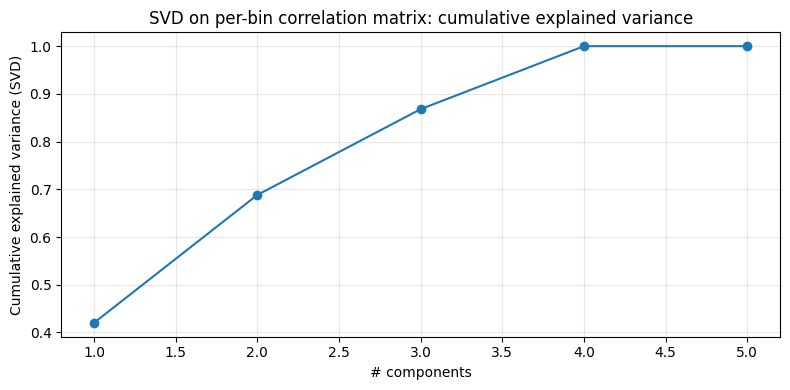

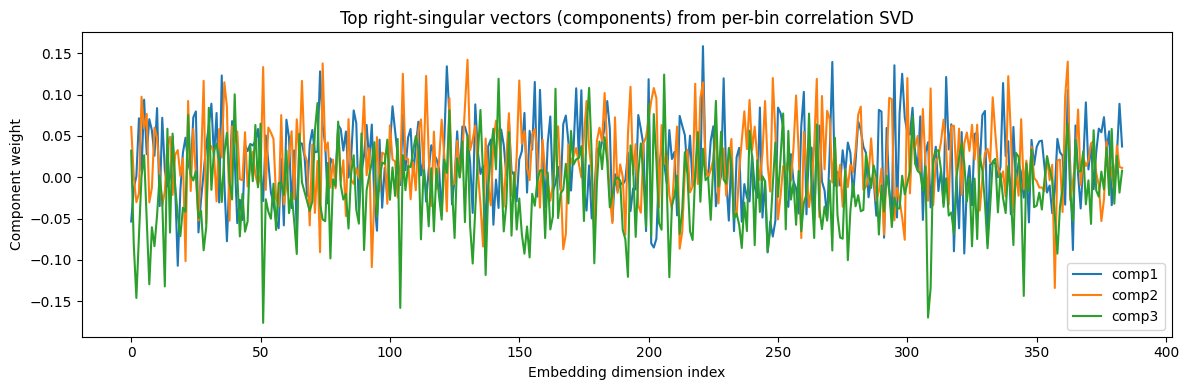

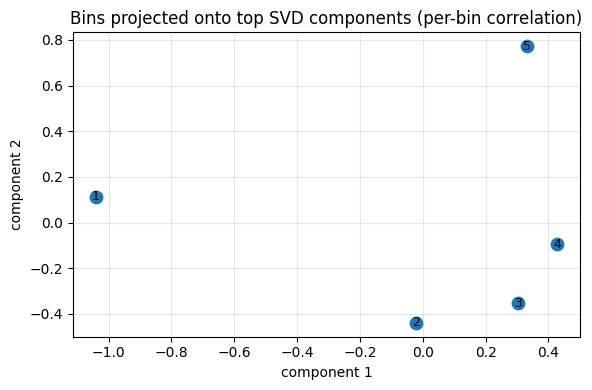

In [12]:
import numpy.linalg as npl
from sklearn.decomposition import TruncatedSVD

# 1) SVD on per-bin correlation matrix
valid_bins = [b for b in bins if not np.all(np.isnan(corrs_by_bin[b]))]
if len(valid_bins) == 0:
	raise RuntimeError("No valid correlation bins to run SVD on")

CorrMat = np.vstack([corrs_by_bin[b] for b in valid_bins])  # shape (B x D)
CorrMat_centered = CorrMat - CorrMat.mean(axis=0)

U_c, S_c, Vt_c = npl.svd(CorrMat_centered, full_matrices=False)
explained = (S_c ** 2) / np.sum(S_c ** 2)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(S_c) + 1), explained.cumsum(), marker="o")
plt.xlabel("# components")
plt.ylabel("Cumulative explained variance (SVD)")
plt.title("SVD on per-bin correlation matrix: cumulative explained variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(min(3, Vt_c.shape[0])):
	plt.plot(Vt_c[i], label=f"comp{i+1}")
plt.xlabel("Embedding dimension index")
plt.ylabel("Component weight")
plt.title("Top right-singular vectors (components) from per-bin correlation SVD")
plt.legend()
plt.tight_layout()
plt.show()

# Project bins into component space
bin_coords = (U_c * S_c)
plt.figure(figsize=(6, 4))
plt.scatter(bin_coords[:, 0], bin_coords[:, 1], s=80)
for i, b in enumerate(valid_bins):
	plt.text(bin_coords[i, 0], bin_coords[i, 1], str(b), fontsize=9, ha="center", va="center")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("Bins projected onto top SVD components (per-bin correlation)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Explained variance ratio (approx): [0.03725662 0.06192852 0.08527568 0.10699089 0.12753563]


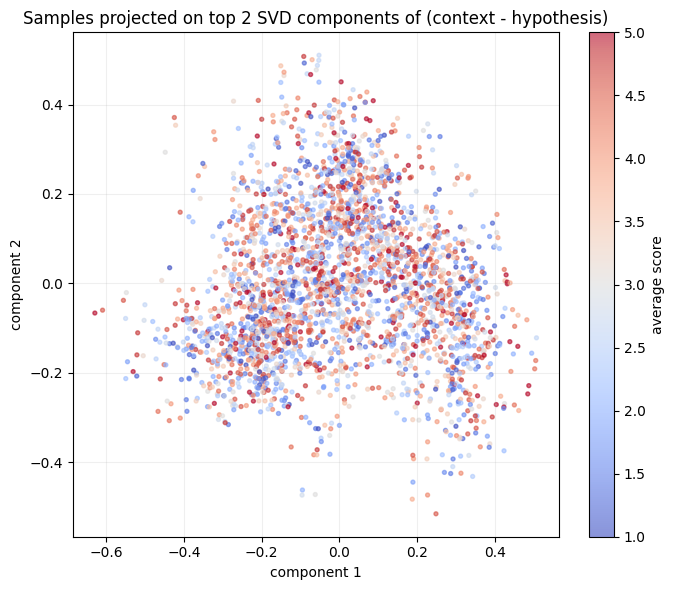

Proj comp1 vs average: r=0.0202, p=2.79e-01
Proj comp2 vs average: r=0.0281, p=1.33e-01
Top positive contributing dims (first comp): [ 82 147 379  76  23 224 295 142 194 148]
Top negative contributing dims (first comp): [244 343 367 261  21 159 235 358  64 162]


In [13]:
# 2) SVD on sample-level difference matrix (context - hypothesis)
M = emb_ctx - emb_hyp  # n x D
M_centered = M - M.mean(axis=0)

# Use randomized/truncated SVD for speed (we only need a few components)
n_components = 10
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(M_centered)
S_s = svd.singular_values_
Vt_s = svd.components_  # shape (n_components, D)

print("Explained variance ratio (approx):", svd.explained_variance_ratio_.cumsum()[:5])

# Project samples to top 2 components
proj = svd.transform(M_centered)[:, :2]

plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=df["average"], cmap="coolwarm", s=8, alpha=0.6)
plt.colorbar(sc, label="average score")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("Samples projected on top 2 SVD components of (context - hypothesis)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Correlate projections with average
from scipy.stats import pearsonr
for i in range(2):
	r, p = pearsonr(proj[:, i], df["average"].values)
	print(f"Proj comp{i+1} vs average: r={r:.4f}, p={p:.2e}")

# Show top contributing dimensions for first component
topk = 10
v1 = Vt_s[0]
ix_pos = np.argsort(-v1)[:topk]
ix_neg = np.argsort(v1)[:topk]
print("Top positive contributing dims (first comp):", ix_pos)
print("Top negative contributing dims (first comp):", ix_neg)

### Quantify separation and inspect driving examples

Compute per-bin means on the SVD sample projections, run an ANOVA / pairwise t-tests for component 1 to confirm significance, plot the mean component1 per bin, and show example items that are most extreme on component 1 (leftmost/rightmost).

             mean       std    n
avg_bin                         
1        0.001739  0.216299  290
2       -0.005098  0.208833  699
3       -0.002900  0.202533  686
4        0.000638  0.199973  706
5        0.009441  0.212115  487
ANOVA comp1 across bins: F=0.401, p=8.08e-01
t-test bin1 vs bin2: t=0.457, p=6.48e-01
t-test bin1 vs bin3: t=0.312, p=7.55e-01
t-test bin1 vs bin4: t=0.075, p=9.41e-01
t-test bin1 vs bin5: t=-0.484, p=6.29e-01


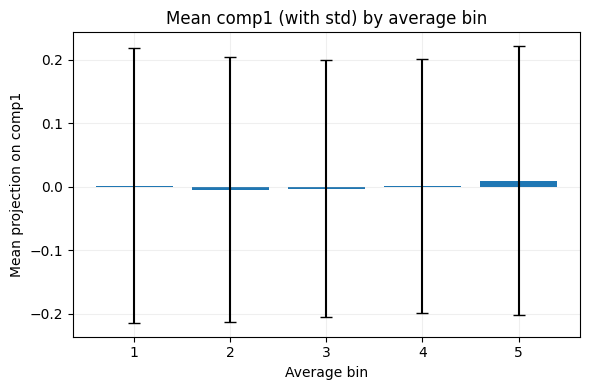


Top 6 leftmost (most negative comp1) examples (comp1):


,homonym,average,context,hypothesis,comp1
0,try,5.0,John had faced challenges in his career before...,"The definition of ""try"" is: ""make an effort or...",-0.629538
1,try,4.6,John had faced challenges in his career before...,"The definition of ""try"" is: ""make an effort or...",-0.609756
2,try,4.6,John had faced challenges in his career before...,"The definition of ""try"" is: ""make an effort or...",-0.555987
3,overboard,2.6,John had always been a bit reckless. That afte...,"The definition of ""overboard"" is: ""to extremes...",-0.550362
4,steps,2.2,John had a big job interview in the city. He l...,"The definition of ""steps"" is: ""support consist...",-0.549923
5,overboard,3.0,John had always been a bit reckless. That afte...,"The definition of ""overboard"" is: ""to extremes...",-0.548420



Top 6 rightmost (most positive comp1) examples (comp1):


,homonym,average,context,hypothesis,comp1
0,suits,2.6,Lena opened her own small fashion business las...,"The definition of ""suits"" is: ""a set of garmen...",0.507754
1,evolved,4.4,Lena had been working on the project for month...,"The definition of ""evolved"" is: ""work out"" as ...",0.505815
2,evolved,4.4,Lena had been working on the project for month...,"The definition of ""evolved"" is: ""work out"" as ...",0.503153
3,suits,2.0,Lena opened her own small fashion business las...,"The definition of ""suits"" is: ""a set of garmen...",0.495406
4,evolved,5.0,Lena had been working on the project for month...,"The definition of ""evolved"" is: ""undergo devel...",0.488020
5,evolved,5.0,Lena had been working on the project for month...,"The definition of ""evolved"" is: ""undergo devel...",0.485357


In [14]:
from scipy.stats import f_oneway, ttest_ind
import numpy as np

# Prepare DataFrame for projections
proj_df = pd.DataFrame(proj[:, :2], columns=["comp1", "comp2"])  # n x 2
proj_df["avg_bin"] = df["avg_bin"].values
proj_df["average"] = df["average"].values

# Per-bin stats for comp1
grouped = proj_df.groupby("avg_bin")["comp1"]
means = grouped.mean()
stds = grouped.std()
counts = grouped.count()
stats_df = pd.DataFrame({"mean": means, "std": stds, "n": counts})
print(stats_df)

# ANOVA across bins for comp1
groups = [proj_df.loc[proj_df["avg_bin"] == b, "comp1"].values for b in sorted(proj_df["avg_bin"].unique())]
fstat, pval = f_oneway(*groups)
print(f"ANOVA comp1 across bins: F={fstat:.3f}, p={pval:.2e}")

# Pairwise t-tests between bin1 and others
bin1 = proj_df.loc[proj_df["avg_bin"] == 1, "comp1"].values
for b in sorted(proj_df["avg_bin"].unique()):
	if b == 1:
		continue
	arr = proj_df.loc[proj_df["avg_bin"] == b, "comp1"].values
	t, p = ttest_ind(bin1, arr, equal_var=False)
	print(f"t-test bin1 vs bin{b}: t={t:.3f}, p={p:.2e}")

# Plot mean comp1 per bin
plt.figure(figsize=(6, 4))
plt.bar(stats_df.index.astype(str), stats_df["mean"], yerr=stats_df["std"], capsize=4)
plt.xlabel("Average bin")
plt.ylabel("Mean projection on comp1")
plt.title("Mean comp1 (with std) by average bin")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Show extreme examples along comp1
n_show = 6
leftmost_idx = np.argsort(proj[:, 0])[:n_show]
rightmost_idx = np.argsort(proj[:, 0])[-n_show:][::-1]

def show_examples(idxs, side="leftmost"):
	print(f"\nTop {n_show} {side} examples (comp1):")
	rows = df.iloc[idxs][["homonym", "average", "context", "hypothesis"]].copy()
	rows["comp1"] = proj[idxs, 0]
	display(rows.reset_index(drop=True))

show_examples(leftmost_idx, side="leftmost (most negative comp1)")
show_examples(rightmost_idx, side="rightmost (most positive comp1)")

### Fine-tune all-MiniLM to align cosine similarity with average score 🔧

This cell adds an optional fine-tuning step to nudge the model so that the cosine similarity between **context** and **hypothesis** correlates linearly with the `average` score. The training objective uses the cosine similarity loss with target labels scaled from 0..1 (average 1→0, 5→1).

Train examples: 2280, Val examples: 588
Starting epoch 1/12
Starting epoch 1/12


Step,Training Loss


Epoch 1 train MSE: 0.075986, val MSE: 0.082490
Starting epoch 2/12
Starting epoch 2/12


Step,Training Loss


Epoch 2 train MSE: 0.066815, val MSE: 0.079090
Starting epoch 3/12
Starting epoch 3/12


Step,Training Loss


Epoch 3 train MSE: 0.059238, val MSE: 0.076731
Starting epoch 4/12
Starting epoch 4/12


Step,Training Loss


Epoch 4 train MSE: 0.052909, val MSE: 0.075376
Starting epoch 5/12
Starting epoch 5/12


Step,Training Loss


Epoch 5 train MSE: 0.047629, val MSE: 0.075031
Starting epoch 6/12


Step,Training Loss


Epoch 6 train MSE: 0.043286, val MSE: 0.075480
Starting epoch 7/12
Starting epoch 7/12


Step,Training Loss


Epoch 7 train MSE: 0.039741, val MSE: 0.076490
Starting epoch 8/12
Starting epoch 8/12


Step,Training Loss


Epoch 8 train MSE: 0.036853, val MSE: 0.077816
Starting epoch 9/12
Starting epoch 9/12


Step,Training Loss


Epoch 9 train MSE: 0.034529, val MSE: 0.079234
Starting epoch 10/12
Starting epoch 10/12


Step,Training Loss


Epoch 10 train MSE: 0.032678, val MSE: 0.080624
Starting epoch 11/12


Step,Training Loss


Epoch 11 train MSE: 0.031194, val MSE: 0.081950
Starting epoch 12/12
Starting epoch 12/12


Step,Training Loss


Epoch 12 train MSE: 0.030013, val MSE: 0.083199


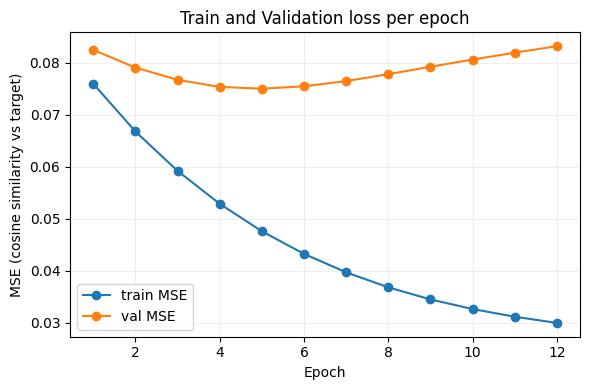

In [45]:
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader
import math
from sklearn.metrics import mean_squared_error

# Fine-tuning settings
EPOCHS = 12
BATCH_SIZE_TRAIN = 16
LR = 1e-5
OUTPUT_DIR = "../allminilm-ft-cosine"

# Use only train.json for training and dev.json for validation
train_df = train.reset_index(drop=True)
val_df = dev.reset_index(drop=True)

# Ensure required text fields exist in train/val (compute them like we did for merged df)
for d in (train_df, val_df):
    d["context"] = d.apply(make_context, axis=1)
    d["hypothesis"] = d.apply(make_hypothesis, axis=1)
    d["example"] = d.get("example_sentence", "").astype(str)
    d["definition"] = d["judged_meaning"].astype(str)
    d["word"] = d["homonym"].astype(str)
    d["average"] = d["average"].astype(float)

# Helper functions
def scale_label(avg):
    return float((avg - 1.0) / 4.0)

def examples_from_df(df_in):
    exs = []
    for _, r in df_in.iterrows():
        exs.append(InputExample(texts=[r["context"], r["hypothesis"]], label=scale_label(r["average"])))
    return exs

train_exs = examples_from_df(train_df)
val_exs = examples_from_df(val_df)
print(f"Train examples: {len(train_exs)}, Val examples: {len(val_exs)}")

train_dataloader = DataLoader(train_exs, shuffle=True, batch_size=BATCH_SIZE_TRAIN)
val_sentences1 = [ex.texts[0] for ex in val_exs]
val_sentences2 = [ex.texts[1] for ex in val_exs]
val_scores = [ex.label for ex in val_exs]
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores, name="dev-eval")

# Initialize model and loss
model_ft = SentenceTransformer(MODEL_NAME)
train_loss_module = losses.CosineSimilarityLoss(model_ft)

# Utility to compute MSE between predicted cosine similarity and labels for a set of InputExamples
from sklearn.metrics.pairwise import cosine_similarity

def compute_mse_on_examples(model_local, examples_list, batch_size=256):
    s1 = [ex.texts[0] for ex in examples_list]
    s2 = [ex.texts[1] for ex in examples_list]
    ys = [ex.label for ex in examples_list]
    emb1 = model_local.encode(s1, batch_size=batch_size, convert_to_numpy=True)
    emb2 = model_local.encode(s2, batch_size=batch_size, convert_to_numpy=True)
    cos_sim = cosine_similarity(emb1, emb2).diagonal()
    mse = mean_squared_error(ys, cos_sim)
    return mse

# Training loop with per-epoch train/val loss logging
warmup_steps = math.ceil(len(train_dataloader) * EPOCHS * 0.1)
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}/{EPOCHS}")
    model_ft.fit(train_objectives=[(train_dataloader, train_loss_module)], epochs=1, warmup_steps=warmup_steps, optimizer_params={"lr": LR})
    # compute train and val losses (compute train MSE on subset if large)
    tr_subset = train_exs[:5000] if len(train_exs) > 5000 else train_exs
    tr_mse = compute_mse_on_examples(model_ft, tr_subset)
    va_mse = compute_mse_on_examples(model_ft, val_exs)
    train_losses.append(tr_mse)
    val_losses.append(va_mse)
    print(f"Epoch {epoch+1} train MSE: {tr_mse:.6f}, val MSE: {va_mse:.6f}")
    model_ft.save(f"{OUTPUT_DIR}/epoch-{epoch+1}")

# Plot train and val losses together if available
if len(train_losses) > 0:
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="train MSE", marker='o')
    plt.plot(range(1, len(val_losses)+1), val_losses, label="val MSE", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("MSE (cosine similarity vs target)")
    plt.title("Train and Validation loss per epoch")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    print("No training run — no loss history to plot.")

Batches: 100%|██████████| 23/23 [00:00<00:00, 32.49it/s]



Pearson corr average vs cosine_distance (before): -0.1174
Pearson corr average vs cosine_distance (after / eval model): -0.6438


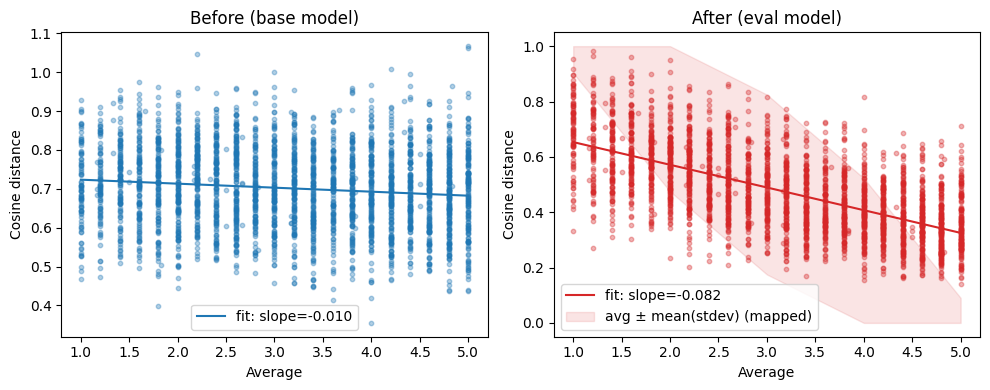

In [47]:
model_eval = SentenceTransformer(OUTPUT_DIR + "/epoch-5")

# Recalculate embeddings (context/hypothesis) and correlation with average
emb_ctx_eval = model_eval.encode(df["context"].tolist(), batch_size=128, convert_to_numpy=True, show_progress_bar=True)
emb_hyp_eval = model_eval.encode(df["hypothesis"].tolist(), batch_size=128, convert_to_numpy=True, show_progress_bar=True)

cos_sim_eval = cosine_similarity(emb_ctx_eval, emb_hyp_eval).diagonal()
cos_dist_eval = 1.0 - cos_sim_eval
corr_before, _ = pearsonr(df["average"].values, df["cosine_distance_ctx_hyp"].values)
corr_after, _ = pearsonr(df["average"].values, cos_dist_eval)
print(f"Pearson corr average vs cosine_distance (before): {corr_before:.4f}")
print(f"Pearson corr average vs cosine_distance (after / eval model): {corr_after:.4f}")

# Plot before vs after (cosine distance)
plt.figure(figsize=(10, 4))
xs = np.linspace(1, 5, 50)

plt.subplot(1, 2, 1)
plt.scatter(df["average"], df["cosine_distance_ctx_hyp"], alpha=0.35, s=10)
plt.title("Before (base model)")
plt.xlabel("Average")
plt.ylabel("Cosine distance")
# Add regression line (before)
ax1 = plt.gca()
coeffs_b = np.polyfit(df["average"].values, df["cosine_distance_ctx_hyp"].values, 1)
ys_b = np.polyval(coeffs_b, xs)
ax1.plot(xs, ys_b, color="C0", linewidth=1.5, label=f"fit: slope={coeffs_b[0]:.3f}")
ax1.legend()

plt.subplot(1, 2, 2)
plt.scatter(df["average"], cos_dist_eval, alpha=0.35, s=10, color="C3")
plt.title("After (eval model)")
plt.xlabel("Average")
plt.ylabel("Cosine distance")

# Add regression line (after)
ax2 = plt.gca()
coeffs = np.polyfit(df["average"].values, cos_dist_eval, 1)
ys = np.polyval(coeffs, xs)
ax2.plot(xs, ys, color="C3", linewidth=1.5, label=f"fit: slope={coeffs[0]:.3f}")

# Compute mean stdev per rounded average bin and plot shaded zone avg +/- stdev mapped to cosine distance
bins = np.arange(1, 6)
Y_low = []
Y_high = []
for b in bins:
    mask = df["average"].round().clip(1, 5) == b
    sigma = df.loc[mask, "stdev"].mean()
    if np.isnan(sigma):
        # fallback to global mean stdev
        sigma = df["stdev"].mean()
    lo = max(1.0, b - sigma)
    hi = min(5.0, b + sigma)
    s_lo = (lo - 1.0) / 4.0
    s_hi = (hi - 1.0) / 4.0
    # convert similarity interval [s_lo, s_hi] to distance interval [1 - s_hi, 1 - s_lo]
    Y_low.append(1.0 - s_hi)
    Y_high.append(1.0 - s_lo)

Y_low = np.array(Y_low)
Y_high = np.array(Y_high)
ax2.fill_between(bins, Y_low, Y_high, color="C3", alpha=0.12, label="avg ± mean(stdev) (mapped)")
ax2.legend()

plt.tight_layout()
plt.savefig("../results/allminilm-training-fit.png")
plt.show()

In [48]:
# Score this model on dev set using ../score/scoring.py
# It uses the ref file in ../deberta-finetune/ref.jsonl (jsonl with id + label list).
# Predictions are produced by mapping cosine similarity from the model to the 1..5 scale:
#   avg_pred = cos_sim * 4.0 + 1.0

import os
import json
import subprocess
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

REF_FILE = "../deberta-finetune/ref.jsonl"
OUT_DIR = "../allminilm-ft-cosine"
PRED_FILE = os.path.join(OUT_DIR, "dev_predictions_epoch-5.jsonl")
SCORE_FILE = os.path.join(OUT_DIR, "dev_score_epoch-5.json")

os.makedirs(OUT_DIR, exist_ok=True)

model_to_use = model_eval
model_name = "model_eval (epoch-5)"

print(f"Encoding and predicting using {model_name}...")

# load reference file (jsonl)
with open(REF_FILE, "r") as f:
    gold_lines = [json.loads(l) for l in f.readlines()]

# build text lists in the same order as the ref file
ctx_texts = []
hyp_texts = []
ids = []
for item in gold_lines:
    idx = int(item["id"])
    # df is available in the notebook (merged train+dev). Use it to fetch context/hypothesis by index.
    row = df.loc[idx]
    ctx_texts.append(row["context"])
    hyp_texts.append(row["hypothesis"])
    ids.append(str(item["id"]))

# encode in batches
emb_ctx_m = model_to_use.encode(ctx_texts, batch_size=128, show_progress_bar=True, convert_to_numpy=True)
emb_hyp_m = model_to_use.encode(hyp_texts, batch_size=128, show_progress_bar=True, convert_to_numpy=True)

# cosine similarity and map to 1..5: avg_pred = cos_sim * 4 + 1
cos_sim_preds = cosine_similarity(emb_ctx_m, emb_hyp_m).diagonal()
avg_preds = (cos_sim_preds * 4.0) + 1.0
avg_preds = avg_preds.clip(1.0, 5.0)

# write predictions jsonl
with open(PRED_FILE, "w") as f:
    for i, pid in enumerate(ids):
        f.write(json.dumps({"id": pid, "prediction": float(avg_preds[i])}) + "\n")

# quick correlation vs gold averages
gold_avgs = [sum(item["label"]) / len(item["label"]) for item in gold_lines]
r, p = pearsonr(avg_preds, gold_avgs)
print(f"Pearson r(pred_avg, gold_avg) = {r:.4f} (p={p:.2e})")

# call scoring.py
res = subprocess.run(["python", "../score/scoring.py", REF_FILE, PRED_FILE, SCORE_FILE], capture_output=True, text=True)
print(res.stdout)
if res.stderr:
    print("Errors/Warnings:\n", res.stderr)

# print final score file content
if os.path.exists(SCORE_FILE):
    with open(SCORE_FILE, "r") as f:
        print("Saved score:", json.load(f))
else:
    print("Score file not created. Check scoring output above.")


Encoding and predicting using model_eval (epoch-5)...


Batches: 100%|██████████| 5/5 [00:00<00:00, 35.92it/s]



Pearson r(pred_avg, gold_avg) = 0.0349 (p=3.98e-01)
Importing...
Starting Scoring script...
Everything looks OK. Evaluating file ../allminilm-ft-cosine/dev_predictions_epoch-5.jsonl on ../deberta-finetune/ref.jsonl
----------
Spearman Correlation: 0.05296985812242822
Spearman p-Value: 0.1996258944031151
----------
Accuracy: 0.5697278911564626 (335/588)
Results dumped into scores.json successfully.

Saved score: {'accuracy': 0.5697278911564626, 'spearman': 0.05296985812242822}
Importing...
Starting Scoring script...
Everything looks OK. Evaluating file ../allminilm-ft-cosine/dev_predictions_epoch-5.jsonl on ../deberta-finetune/ref.jsonl
----------
Spearman Correlation: 0.05296985812242822
Spearman p-Value: 0.1996258944031151
----------
Accuracy: 0.5697278911564626 (335/588)
Results dumped into scores.json successfully.

Saved score: {'accuracy': 0.5697278911564626, 'spearman': 0.05296985812242822}
